In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
valid_emb = pd.read_pickle("../pickle_backups/valid_embeddings2024-06-09T13.45.1717908334.pickle")

In [3]:
# Example data structure
valid_emb_class = pd.DataFrame({
    'query': valid_emb["query"],
    'glove_queries': valid_emb["glove_queries"],
    'sif_queries': valid_emb["sif_queries"],
    'glove_texts': valid_emb["glove_texts"],
    'sif_texts': valid_emb["sif_texts"],
    'chosen': valid_emb['passages'].apply(lambda x: x['is_selected'])
})

In [4]:
def prepare_data(valid_emb, embedding_type):
    X = []
    y = []
    for i, row in valid_emb.iterrows():
        query_embedding = np.array(row[f'{embedding_type}_queries']).flatten()  # Ensure it's a 1D array
        for j, (passage_embedding, chosen) in enumerate(zip(row[f'{embedding_type}_texts'], row['chosen'])):
            passage_embedding = np.array(passage_embedding).flatten()  # Ensure it's a 1D array
            X.append(np.concatenate([query_embedding, passage_embedding]))
            y.append(chosen)
    return np.array(X), np.array(y)


In [5]:
X_glove, y_glove = prepare_data(valid_emb_class, 'glove')
X_sif, y_sif = prepare_data(valid_emb_class, 'sif')

X_glove_train, X_glove_test, y_glove_train, y_glove_test = train_test_split(X_glove, y_glove, test_size=0.2, random_state=42)
X_sif_train, X_sif_test, y_sif_train, y_sif_test = train_test_split(X_sif, y_sif, test_size=0.2, random_state=42)

log_reg_glove = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg_glove.fit(X_glove_train, y_glove_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [6]:
#TODO: this and the stuff below is probably wrong. Reconsider and learn more about this. 
y_glove_pred = log_reg_glove.predict(X_glove_test)
y_glove_prob = log_reg_glove.predict_proba(X_glove_test)[:, 1] 

print("GloVe Embeddings Classifier")
print("Accuracy:", accuracy_score(y_glove_test, y_glove_pred))
print("Classification Report:\n", classification_report(y_glove_test, y_glove_pred))


GloVe Embeddings Classifier
Accuracy: 0.5889017680018692
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.59      0.73    204205
           1       0.09      0.59      0.16     14064

    accuracy                           0.59    218269
   macro avg       0.52      0.59      0.44    218269
weighted avg       0.90      0.59      0.69    218269



In [7]:

log_reg_sif = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg_sif.fit(X_sif_train, y_sif_train)

y_sif_pred = log_reg_sif.predict(X_sif_test)
y_sif_prob = log_reg_sif.predict_proba(X_sif_test)[:, 1] 

print("SIF Embeddings Classifier")
print("Accuracy:", accuracy_score(y_sif_test, y_sif_pred))
print("Classification Report:\n", classification_report(y_sif_test, y_sif_pred))


SIF Embeddings Classifier
Accuracy: 0.5433020722136447
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.54      0.69    204205
           1       0.08      0.56      0.14     14064

    accuracy                           0.54    218269
   macro avg       0.51      0.55      0.41    218269
weighted avg       0.89      0.54      0.65    218269



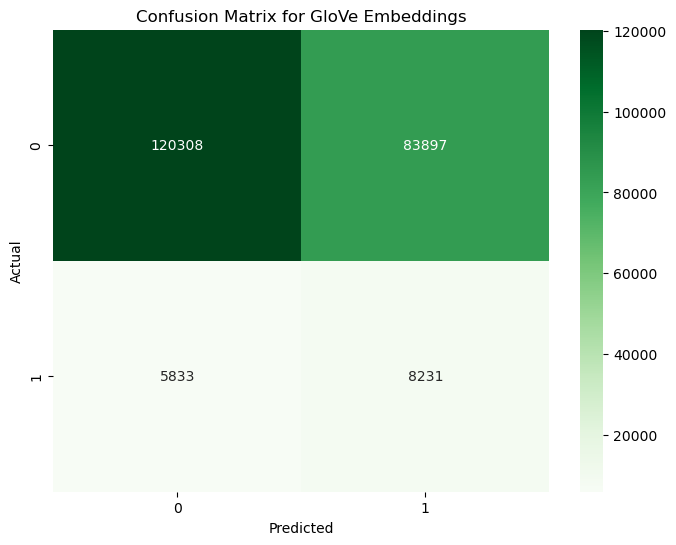

In [8]:
cm_glove = confusion_matrix(y_glove_test, y_glove_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_glove, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix for GloVe Embeddings')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


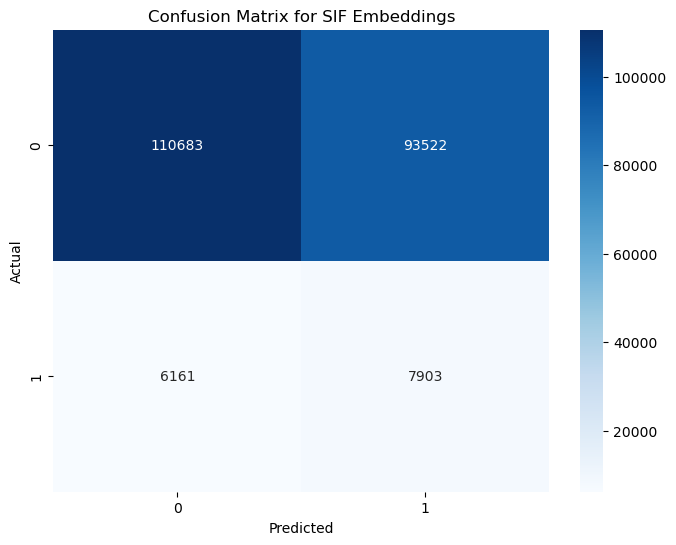

Percentage of correctly identified chosen passages (GloVe): 58.89%
Percentage of correctly identified chosen passages (SIF): 54.33%


In [9]:

cm_sif = confusion_matrix(y_sif_test, y_sif_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_sif, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for SIF Embeddings')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate percentage of correctly identified chosen passages
def calculate_match_percentage(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true) * 100

glove_match_percentage = calculate_match_percentage(y_glove_test, y_glove_pred)
sif_match_percentage = calculate_match_percentage(y_sif_test, y_sif_pred)

print(f"Percentage of correctly identified chosen passages (GloVe): {glove_match_percentage:.2f}%")
print(f"Percentage of correctly identified chosen passages (SIF): {sif_match_percentage:.2f}%")
